# Baseline Model for Handwritten recognition

## Imports

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image

import re
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import sentencepiece

## Loading Data




In [ ]:
def label_preprocessing(labels_sentence, vocabulary):
    '''
    Takes in a single label as a string (sentence matching the content of the image) and
    preprocesses it so that the label can interpreted by the model
    Param: label_sentence: the label a string
    Returns: The preprocessed label as a sequence of indexes
    '''
    max_sequence_length = max(len(sentence) for sentence in labels_sentence )

    labels_indexes = [[vocabulary[char] for char in sentence] for sentence in labels_sentence]
    preprocesed_label = pad_sequences(labels_indexes, maxlen=max_sequence_length, padding='post')

    return preprocesed_label, max_sequence_length


def get_vocabulary(train_labels):
    """
    creates a vocabulary for the translation of the prediction
    """
    vocabulary = sorted(set(''.join(train_labels)))
    vocabulary_dict = {char: index for index, char in enumerate(vocabulary)}
    return vocabulary_dict

In [ ]:
vocabulary = get_vocabulary(train_labels)
train_labels_preprocessed, max_sequence_length = label_preprocessing(train_labels, vocabulary)

## Metric Functions

In [ ]:
def word_error_rate(y_true, y_pred):
    """
    returns calculation of Word Error Rate for a prediction.
    """
    wer_value = wer(y_true, y_pred)
    return wer_value

def character_error_rate(y_true, y_pred):
    """
    returns calculation of Character Error Rate for a prediction.
    """
    matcher = difflib.SequenceMatcher(None, y_true, y_pred)
    cer_value = 1 - matcher.ratio()
    return cer_value

# Donut Model fine-tuning

# Loading Data

In [5]:
! unzip /content/test_bw.zip

Archive:  /content/test_bw.zip
   creating: test_bw/
  inflating: test_bw/g04-048-00.png  
  inflating: test_bw/g06-037d-07.png  
  inflating: test_bw/r06-090-01.png  
  inflating: test_bw/a04-054-01.png  
  inflating: test_bw/n01-031-07.png  
  inflating: test_bw/c01-009-03.png  
  inflating: test_bw/g06-018p-01.png  
  inflating: test_bw/p03-004-03.png  
  inflating: test_bw/e06-070-02.png  
  inflating: test_bw/b06-015-09.png  
  inflating: test_bw/l04-113-04.png  
  inflating: test_bw/e06-021-03.png  
  inflating: test_bw/c02-012-04.png  
  inflating: test_bw/c02-049-08.png  
  inflating: test_bw/f04-064-03.png  
  inflating: test_bw/b04-134-02.png  
  inflating: test_bw/b03-109-07.png  
  inflating: test_bw/d04-012-10.png  
  inflating: test_bw/m04-200-06.png  
  inflating: test_bw/m04-145-05.png  
  inflating: test_bw/a05-062-08.png  
  inflating: test_bw/g06-050k-02.png  
  inflating: test_bw/l01-105-06.png  
  inflating: test_bw/r06-090-06.png  
  inflating: test_bw/a01-058u-08

<class 'PIL.Image.Image'>


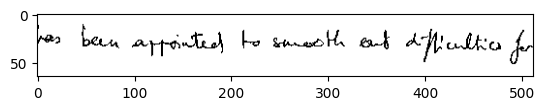

In [6]:
# A TEST FROM THE ORIGINAL CODE:
# from datasets import load_dataset
# dataset = load_dataset("hf-internal-testing/example-documents", split="test")
# image = dataset[2]["image"]

# OUR CODE:
folder_path = '/content/test_bw'  # Replace 'folder_name' with the actual folder name

images = []
for file_name in os.listdir(folder_path):
  image_path = os.path.join(folder_path, file_name)
  image = Image.open(image_path).convert("RGB")
  images.append(image)

# test
image = images[1]
print(type(image))
plt.imshow(image)
plt.show()

In [7]:
labels_head = pd.read_csv('/content/labels_500_bw.csv', sep='\t', header=None)
display(labels_head.head())
labels = labels_head.iloc[:,1].to_numpy()
labels.shape

,0,1
0,a01-000x-04,"and he is to be backed by Mr. Will Griffiths ,"
1,a01-007u-02,sentiment would still favour the abolition
2,a01-007u-06,Nationalist Parties of Northern Rhodesia
3,a01-007u-07,have agreed to get together to face
4,a01-011-04,violently opposed to Africans getting an elect...


(500,)

# Model

In [8]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2",
                                                  return_dict_in_generate=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# prepare decoder inputs
task_prompt = "<s_cord-v2>"
# task_prompt = "Read the handwritten text present in this picture"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
predictions = list()
pattern = r">(.*?)<"


for idx, image in enumerate(images[:5]):
  pixel_values = processor(image, return_tensors="pt").pixel_values


  outputs = model.generate(
      pixel_values.to(device),
      decoder_input_ids=decoder_input_ids.to(device),
      max_length=model.decoder.config.max_position_embeddings,
      early_stopping=True,
      pad_token_id=processor.tokenizer.pad_token_id,
      eos_token_id=processor.tokenizer.eos_token_id,
      use_cache=True,
      num_beams=1,
      bad_words_ids=[[processor.tokenizer.unk_token_id]],
      return_dict_in_generate=True,)

  sequence = processor.batch_decode(outputs.sequences)[0]
  sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
  # print(processor.token2json(sequence))

  # my modifications :
  # sentence = re.findall(pattern, sequence)
  # print(f"Image {idx} predict: {sentence}")
  predictions.append(processor.token2json(sequence))



In [11]:
predictions

[{'text_sequence': ' the inbom child os much as to the</s_total>'},
 {'text_sequence': ' been apported to suncoth eat difficultio for</s_total>'},
 {'text_sequence': ' Niko hor to corne conditie wilh us.</s_changeprice></s_total>'},
 {'text_sequence': ' have to leave the learned either sitin</s_total>'},
 {'text_sequence': ' will was reduced; since 1957 it has again declined. Uost of the</s_total>'}]

## Prediction

In [ ]:
index_to_char = {v: k for k, v in vocabulary.items()}
cer_sum = 0
wer_sum = 0

for i, sentence in enumerate(predictions):
    cer_sum += character_error_rate(test_labels[i], sentence)
    wer_sum += word_error_rate(test_labels[i], sentence)

print('CER mean: ', cer_sum / len(test_labels))
print('WER mean: ', wer_sum / len(test_labels))

CER mean:  0.008279569892473117
WER mean:  0.01
